In [3]:
import numpy as np
import pandas as pd
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras import optimizers
from keras.models import Model

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

In [4]:
from tensorflow.python.client import device_lib
# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6044510716843589394
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2657746944
locality {
  bus_id: 1
}
incarnation: 11742031193868892202
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [5]:
path = "/mnt/ML-drive/scanner-ml/Artem/share/Valerio/"
class_names = ['C100keV','TestSample']
n_pols = 8

In [6]:
def load_images(path, name_dir='TestSample', n_pols=8):
    
    img_ind = []
    path = path+name_dir+"/crops/"
    img_names = os.listdir(path)
    for name in img_names:
        img_ind.append(re.split('[_.]',name))
    img_ind = pd.DataFrame(np.array(img_ind),columns=['ViewID','gr','GrainID','pol','Polarization','cl','ClusterID','csv'])
    img_ind = img_ind.drop(['csv'],axis=1).sort_values(['ViewID','GrainID','Polarization'])
    for view in np.unique(img_ind['ViewID']):
        view_imgs = img_ind[ img_ind['ViewID']==view ]
        for grain in np.unique(view_imgs['GrainID']):
            grain_imgs = view_imgs[ view_imgs['GrainID']==grain ]
            if grain_imgs.shape[0]!=8:
                img_ind = img_ind.drop(grain_imgs.index)
    img_names = []
    for name in img_ind.values:
        img_names.append('_'.join(name)+'.csv')
    
    i=0
    im_array = []
    for name in img_names:
        if i==0 : tmp_im = []
        tmp_im.append(pd.read_csv(path+name, header=None).drop(31, axis=1).values)
        i+=1
        if i==n_pols:
            im_array.append(np.array(tmp_im).T)
            i=0
    return np.array(im_array)

In [7]:
%%time
X_sign = load_images(path, 'C100keV')
y_sign = np.ones((X_sign.shape[0],1))
X_noise = load_images(path, 'TestSample')
y_noise = np.zeros((X_noise.shape[0],1))

X = np.vstack((X_sign, X_noise))
y = np.vstack((y_sign, y_noise))

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Normalize image vectors (????)
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 19703
number of test examples = 3478
X_train shape: (19703, 31, 31, 8)
Y_train shape: (19703, 1)
X_test shape: (3478, 31, 31, 8)
Y_test shape: (3478, 1)
CPU times: user 8min 36s, sys: 10.2 s, total: 8min 46s
Wall time: 9min 22s


# Sergey-like VGG model

In [8]:
def VGG_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, activation='relu', name='conv1_1')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(64, 3, name='conv1_2')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(128, 3, name='conv2')(X)
    #X = BatchNormalization(name='batch2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool2')(X)
    print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop_middle')(X)
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256, 3, name='conv3')(X)
    #X = BatchNormalization(name='batch3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool3')(X)
    print('conv3\t',X.get_shape())
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512, 3, name='conv4')(X)
    #X = BatchNormalization(name='batch4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool4')(X)
    print('conv4\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = X, name='VGG_model')
    return model

In [24]:
model = VGG_model(input_shape=(31,31,8))

conv1	 (?, 15, 15, 64)
conv2	 (?, 7, 7, 128)
conv3	 (?, 3, 3, 256)
conv4	 (?, 1, 1, 512)


In [25]:
adamka = keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=adamka, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
hist = model.fit(X_train, Y_train, epochs = 100, batch_size = 32, validation_split=0.15, verbose=1)

Train on 16747 samples, validate on 2956 samples
Epoch 1/100
16747/16747 [==============================] - 15s 912us/step - loss: 0.7965 - acc: 0.6274 - val_loss: 0.6050 - val_acc: 0.6888
Epoch 2/100
16747/16747 [==============================] - 15s 877us/step - loss: 0.6056 - acc: 0.6807 - val_loss: 0.5743 - val_acc: 0.6911
Epoch 3/100
16747/16747 [==============================] - 15s 890us/step - loss: 0.5658 - acc: 0.7034 - val_loss: 0.5486 - val_acc: 0.7693
Epoch 4/100
16747/16747 [==============================] - 15s 880us/step - loss: 0.5380 - acc: 0.7251 - val_loss: 0.5095 - val_acc: 0.7693
Epoch 5/100
16747/16747 [==============================] - 29s 2ms/step - loss: 0.5077 - acc: 0.7563 - val_loss: 0.4690 - val_acc: 0.8237
Epoch 6/100
16747/16747 [==============================] - 65s 4ms/step - loss: 0.4703 - acc: 0.7891 - val_loss: 0.4213 - val_acc: 0.8400
Epoch 7/100
16747/16747 [==============================] - 60s 4ms/step - loss: 0.4320 - acc: 0.8108 - val_loss: 0.

16747/16747 [==============================] - 73s 4ms/step - loss: 0.2007 - acc: 0.9184 - val_loss: 0.1665 - val_acc: 0.9364
Epoch 60/100
16747/16747 [==============================] - 77s 5ms/step - loss: 0.2081 - acc: 0.9147 - val_loss: 0.1705 - val_acc: 0.9361
Epoch 61/100
16747/16747 [==============================] - 69s 4ms/step - loss: 0.2018 - acc: 0.9171 - val_loss: 0.1668 - val_acc: 0.9361
Epoch 62/100
16747/16747 [==============================] - 73s 4ms/step - loss: 0.1969 - acc: 0.9212 - val_loss: 0.2195 - val_acc: 0.9164
Epoch 63/100
16747/16747 [==============================] - 74s 4ms/step - loss: 0.1982 - acc: 0.9206 - val_loss: 0.1972 - val_acc: 0.9293
Epoch 64/100
16747/16747 [==============================] - 74s 4ms/step - loss: 0.1921 - acc: 0.9227 - val_loss: 0.1912 - val_acc: 0.9283
Epoch 65/100
16747/16747 [==============================] - 74s 4ms/step - loss: 0.1904 - acc: 0.9252 - val_loss: 0.1723 - val_acc: 0.9327
Epoch 66/100
16747/16747 [==============

In [27]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3478/3478 [==============================] - 1s 288us/step
Loss = 0.20641511840646196
Test Accuracy = 0.9177688325596239


/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


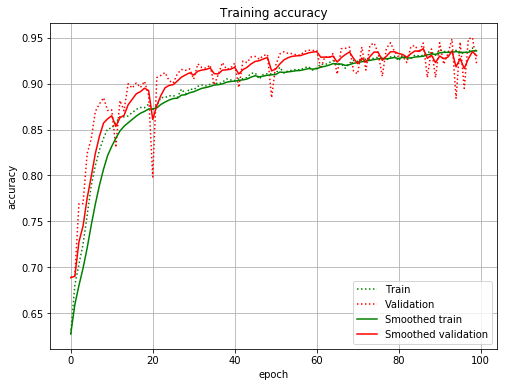

In [33]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(hist.history['acc'], "g:", label='Train')
plt.plot(hist.history['val_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist.history['acc']),span=5), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist.history['val_acc']),span=5), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.savefig('acc-2D.pdf')
plt.show()

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


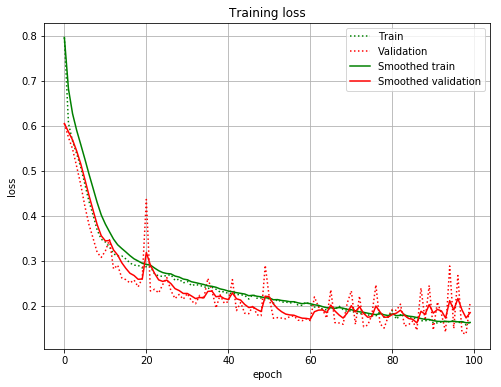

In [35]:
plt.figure(figsize=(8,6))
plt.title('Training loss')
plt.plot(hist.history['loss'], "g:", label='Train')
plt.plot(hist.history['val_loss'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist.history['loss']),span=5), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist.history['val_loss']),span=5), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.savefig('loss-2D.pdf')
plt.show()

# Sergey-like VGG model with BatchNorm

In [131]:
def VGG_b_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, activation='relu', name='conv1_1')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(64, 3, name='conv1_2')(X)
    X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(128, 3, name='conv2')(X)
    X = BatchNormalization(name='batch2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool2')(X)
    print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop_middle')(X)
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256, 3, name='conv3')(X)
    X = BatchNormalization(name='batch3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool3')(X)
    print('conv3\t',X.get_shape())
    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256, 3, name='conv4')(X)
    X = BatchNormalization(name='batch4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool4')(X)
    print('conv4\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = X, name='VGG_b_model')
    return model

In [132]:
model_b = VGG_b_model(input_shape=(31,31,8))

conv1	 (?, 15, 15, 64)
conv2	 (?, 7, 7, 128)
conv3	 (?, 3, 3, 256)
conv4	 (?, 1, 1, 256)


In [133]:
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [134]:
model_b.fit(X_train, Y_train, epochs = 30, batch_size = 256, validation_split=0.15)

Train on 16747 samples, validate on 2956 samples
Epoch 1/30
16747/16747 [==============================] - 13s 773us/step - loss: 0.2887 - acc: 0.9027 - val_loss: 7.0560 - val_acc: 0.3041
Epoch 2/30
16747/16747 [==============================] - 10s 571us/step - loss: 0.1174 - acc: 0.9612 - val_loss: 5.3167 - val_acc: 0.3045
Epoch 3/30
16747/16747 [==============================] - 9s 566us/step - loss: 0.0817 - acc: 0.9735 - val_loss: 5.9269 - val_acc: 0.3048
Epoch 4/30
16747/16747 [==============================] - 9s 567us/step - loss: 0.0685 - acc: 0.9759 - val_loss: 3.5270 - val_acc: 0.3045
Epoch 5/30
16747/16747 [==============================] - 9s 567us/step - loss: 0.0579 - acc: 0.9796 - val_loss: 7.5938 - val_acc: 0.3045
Epoch 6/30
16747/16747 [==============================] - 10s 573us/step - loss: 0.0549 - acc: 0.9813 - val_loss: 0.8849 - val_acc: 0.6962
Epoch 7/30
16747/16747 [==============================] - 10s 576us/step - loss: 0.0485 - acc: 0.9829 - val_loss: 4.8909

In [135]:
preds = model_b.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3478/3478 [==============================] - 1s 321us/step
Loss = 10.488739654481789
Test Accuracy = 0.31196089715296815
